##### Let's try to understand Support Vector Machines and how to implement them in financial markets

Just as any other machine learning algorithm does, a support vector machine (SVM) takes data as input, attempts to find & recognize patterns, and then tells us what it learned.  Support vector machines fall into the category of supervised learning, which means that it creates a function that will map a given input to an output.  More specifically, a SVM is a classification algorithm.

Before we can start implementing trading algorithms and seeking alpha, let's figure out how an SVM works
### Maximal Margin Classifier
The support vector machine algorithm comes from the maximial margin classifier.  The **maximal margin classifier** uses the distance from a given decision boundary to classify an input.  The greater the distance, or *margin* , the better the classifier is at handling the data. On a catesian plane, the boundary can be thought of as a line.  In three dimensional space, it is a plane, but after than it becomes hard to conceptualize. This boundary can be better thought of as a **hyperplane**, specifically one of dimension $p-1$, where $p$ is the dimension of the data point.
Our boundary, or hyperplane, is known as a seperating hyperplane, because it is used to seperate the data points into desired categories. In general, there are many hyperplanes that can seperate a given data set, but the one we care about is the *maximal margin hyperplane* or the *optimal separating hyperplane*.  This separating hyperplane is the one with the largest minimum distance from each data point in the training set.  By using this hyperplane to classify a data point from the test set, we have the maximal margin classifier.

![](graph1.jpg)

The line in the graph above represents the hyperplane.  Notice that it completely seperates all of the points in the blue and purple regions of the graph.

Now the maximal margin classifier works, to a degree.  If you have a data set which cannot be separated by a hyperplane, you can no longer use this.  Sometimes, you may run into a data that has more than two categories, which makes a linear boundary useless.

![](svmmeme1.jpg)

At this point, you have to consider you options.  
1. You can base your classifier on the seperating hyperplane as explained earlier.  But the hyperplane doesn't exist...so you have no classifier.
2. Consider a classifier that isn't perfect, but it can work some/most of the time

### Support Vector Classifier
I like the second option too.  By using a classifier that isn't perfect, you can at least handle most observations, and introduce a level of adaptation to the model when it is presented with new data.

This evolution of the maximal margin classifier is known as the **support vector classifier** (SVC), or the soft margin classifier.  Instead of being exact and not very robust in its classification, the SVC allows some observations to be on the wrong side of the margin and/or hyperplane (where the soft comes from), for the sake of getting classification mostly correct.

Without getting into too much math, the algorithm determines which side of the hyperplane an observation will lie on by finding a solution to an optimization problem that uses a tuning parameter, the width of the margin (which it tries to maximize) and slack variables.

The tuning parameter is used to control the bias-variance tradeoff.  When it is small, the classifier fits the data well as the margins are small.  In other words, low bias, high variance.  A larger tuning parameter is the opposite.  It allows for more observations to be on the wrong side of the margin allowing for high bias and low variance.

Slack variables in particular are pretty cool.  They allow data points to be on the side of the margin or hyperplane.  They are also used to transform inequalities into equalities.  The values that the slack values take on can also tell us about the behavior of a given data point. If the slack variable for a given data point is equal to 0, then that data point is on the right side of the margin.  If the slack variable is greater than 0 but less than 1, the data point is on the wrong side of the margin, but on the right side of the hyperplane.  If the slack variable is greater than 1, the data point is on the wrong side of the hyper plane.

The main reason this optimization matters is its affect on the hyperplane. The only values that affect the hyperplane, and in turn how data points are classified, are those that are on the margin, or on the wrong side of it.  If an object is on the right side of the hyperplane, it has not affect on it.  The classifer gets its name from the former data points, as they are known as **support vectors**.

### Finally, Support Vector Machines
The support vector machines builds on the optimization in support vector classifiers by growing the feature space by using **kernels**. 

Kernels, similar to the previous optimization, uses a fair bit of math.  Put simply, kernels tell us how similar data points are.  By assigning weights to to sequences of data, it can identify how similar two points are, given that it has learned how to compare them.  Kernels allow data to be processed in simpler terms, as opposed to being done in a higher dimensional space.  More specifically, it computes inner products between all possible outputs of all of the pairs of data points in the feature space.  By using kernels instead of enlarging the feature space, the algorithm can be much more efficient.  It uses one function to compare pairs of distinct data points as opposed to using functions for original features in the data set.

Many different kernels exist including the RBF kernel, graph kernels, the linear kernel, polynomial kernel.  For example, the linear kernel compares a pair of data points by using their bivariate correlation.  The polynomial kernel attempts to fit an SVC in a higher dimensional space. A support vector classifier is the same as using an SVM with a polynomial kernel of degree 1.

Basically, the main goal of the Support Vector Machine is to construct a hyperplane, which it then uses to classify data.  Despite generally being categorized as a classification algorithm, there is an extension of the Support Vector Machine used for regression, known as *Support Vector Regression*.

### Support Vector Machines for Trading

Before I get into this application, know that this is by no means advice on how/what you should trade.  That's on you.

We'll start by gathering our data.

We'll use a time period going back about five years, October 28, 2014 to October 28, 2019.  The stocks that we will get price data for are the components of the Dow Jones Industrial Average.

Yahoo Finance used to be really easy to get data from, but most packages no longer work, so we'll also create a web scraper in the process.

The first thing we'll do is import all of the packages we'll need.

#### Webscraping Data

In [1]:
from bs4 import BeautifulSoup
import datetime
import json
import numpy as np
import pandas as pd
import requests
import time
import warnings
warnings.simplefilter('ignore')

Then we'll use the requests package to scrape the contents of [this](https://finance.yahoo.com/quote/%5EDJI/components?p=%5EDJI) page on Yahoo Finance. The page contains the names of the companies that make up the Dow Jones Industrial Average, as well as their tickers. Next, we'll use BeautifulSoup4 to make the information in Dow_Content searchable.

In [2]:
Dow_Page = requests.get('https://finance.yahoo.com/quote/%5EDJI/components?p=%5EDJI')
Dow_Content = Dow_Page.content

soup = BeautifulSoup(Dow_Content)

data = list(soup.findAll("td",{"class":"Py(10px) Ta(start) Pend(10px)"}))

The lines above parse the data gathered from the webpage and search for the bit of HTML code that corresponds to the table on the page.  This can be found by right click on the area of the page, inspecting the element, and with a little investigation you can find the class name used above.

There will be two types of lines that the search will come across:
1. Lines containing the ticker
2. Lines containing the company name with no ticker

We don't care for the latter, so when the loop finds them, it ignores that bit and moves on.  A few string operations to trim the extra fat and we have our ticker.  Each ticker is then added to a list for safe keeping.

In [3]:
Ticker_List = []
for i in data:
    TempData = str(i)
    if "title" in TempData:
        TempData = TempData[TempData.find("title"):]
        TempData = TempData[TempData.find(">")+1:TempData.find("<")]
        Ticker_List.append(TempData)
    else:
        continue

Yahoo Finance uses a Unix time stamp in their url, so we make use of the `time` package to convert our start and end dates to the desired format.  It can take either `struct_time` (more about that [here](https://docs.python.org/2/library/time.html#time.struct_time)) or a tuple of 9 time arguments.  We don't really care for anything past the date here.

In [4]:
Start_Date = int(time.mktime((2014,10,28,4,0,0,0,0,0)))
End_Date = int(time.mktime((2019,10,28,4,0,0,0,0,0)))

The `ScrapeYahoo` function takes three arguments:
1. ticker, a string representing a given stock
2. start, a unix timestamp representing the start date 
3. end, a unix timestamp representing the current day

It combines these with the base url for Yahoo Finance and gets the data from the desired web page.  Instead of processing it like we did earlier, we parse the JSON data from the page.  Yahoo Finance uses cookies now, and simply using the HTML code will throw an error.

The lines after parse the content of the JSON data.  Something that helped a lot while I was initially exploring the dataset was the `keys()` method for Python dictionaries.  It made traversing the JSON data much easier.  You can read about it [here](https://www.programiz.com/python-programming/methods/dictionary/keys)

In [5]:
def ScrapeYahoo(data_df,ticker, start, end):
    
    #Form the URL to be scraped
    Base_Url = 'https://query1.finance.yahoo.com/v8/finance/chart/'
    Scrape_Url = Base_Url + ticker + "?period1=" + str(start)+"&period2="+str(end)+"&interval=1d"
    
    #Get data from page
    r = requests.get(Scrape_Url)
    Page_Data = r.json()
    
    # Compile data into a DataFrame
    Stock_df = pd.DataFrame()
    Stock_df['DateTime'] = Page_Data['chart']['result'][0]['timestamp']
    Stock_df['DateTime'] = Stock_df['DateTime'].apply(lambda x: datetime.datetime.fromtimestamp(x).date().isoformat())
    Stock_df["Open"] = Page_Data["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    Stock_df["High"] = Page_Data["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    Stock_df["Low"] = Page_Data["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    Stock_df["Close"] = Page_Data["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    Stock_df["Volume"] = Page_Data["chart"]["result"][0]["indicators"]["quote"][0]["volume"]
    Stock_df = Stock_df.set_index("DateTime")
    
    #Add data to a dictionary containing all values
    data_df[ticker] =  Stock_df
    

The `Stock_Data` dictionary will hold our parsed data.  The keys in the dictionary will be the ticker of a given stock.  For each stock, the function `ScrapeYahoo` will create a dateframe containing open, high, low, close, and volume data.

In [6]:
Stock_Data = {}

for i in Ticker_List:
    ScrapeYahoo(Stock_Data, i, Start_Date, End_Date)
    #print(i + " done")
    time.sleep(0.5)

We have historical price data, now what?  Recall that the support vector machine is a classification algorithm.  We're going to attempt to create the features for our model with the help of technical analysis.

Technical analysis is a methodology that uses past data to forecast the future direction of price.  In general, technical indicators use price data and volume in their calculations. The motivation for the indicators chosen come from the papers listed in the references section at the end of the article.

One very important thing to pay attention to before moving on: **look-ahead bias**.
We already have all of the closing data, which is what will be used for calculations.  In a real world scenario, the most you have is the previous day's closing.  We have to make sure our calculations don't take in data that technically had not occurred yet.
To do this, we will *lag* the data. That is, shift our data back one day.
#### Technical Analysis
We will make use of the `talib` library perform the technical analysis calculations.

In [7]:
import talib as ta
from talib import MA_Type

for i in Ticker_List:
    
    Stock_Data[i]['High Shifted']=Stock_Data[i]['High'].shift(-1)
    Stock_Data[i]['Low Shifted'] = Stock_Data[i]['Low'].shift(-1)
    Stock_Data[i]['Close Shifted'] = Stock_Data[i]['Close'].shift(-1)
    
    Stock_Data[i]['Upper BBand'], Stock_Data[i]['Middle BBand'],Stock_Data[i]['Lower BBand']= ta.BBANDS(Stock_Data[i]['Close Shifted'],
                                                                                                       timeperiod=20,)
    
    Stock_Data[i]['RSI'] = ta.RSI(np.array(Stock_Data[i]['Close Shifted']), timeperiod=14)

    Stock_Data[i]['Macd'], Stock_Data[i]['Macd Signal'],Stock_Data[i]['Macd Hist'] = ta.MACD(Stock_Data[i]['Close Shifted'], fastperiod=12, slowperiod=26, 
                                                               signalperiod=9)

    Stock_Data[i]['Momentum'] = ta.MOM(Stock_Data[i]['Close Shifted'],timeperiod=12)
    
    Stock_Data[i]['Returns'] = np.log(Stock_Data[i]['Open']/Stock_Data[i]['Open'].shift(-1)) 

We'll be using our returns column to calculate our label for each trading day.  If returns are 0 or positive, it will be labelled 1, otherwise it will be labelled 0.  Notice that the returns column uses opening prices as opposed to closing prices, to avoid look-ahead bias.

In [8]:
for i in Ticker_List:
    Signal_List = []
    for j in Stock_Data[i]['Returns']:
        
        if (j>=0):
            Signal_List.append("1")
            
        else:
            Signal_List.append("0")
            
    Stock_Data[i]['Signal'] = Signal_List

#### Training the Model
Before we start setting up our model, the data must be normalized.  By doing so, all of the features are scaled and given equal importance when the SVM calculates its distances.

We used the `MaxAbsScaler`, which scales each feature by its maximum absolute value.

Next, we created a dictionary to store the training and testing data.  If NaN values aren't dropped, the model will not run. The variable `X` will contain all of the features of model, which will then be scaled.  It is important to drop the Signal and Returns columns.  We are predicting the Signal, if its keep, the model will be almost perfect.  If we keep the Returns column, it will also influence the model too much.  Remember, the Signal column was initially calculated by using the returns calculated. `Y` is what we want to predict, so we assign it to the column containing signals.

Our model will use 70% of the data to train, and 30% to test on as shown in line 11.

The model is defined by the model variable (in case you were confused). I left various kernel configurations in the notebook linked below that you can play around with.  The model is fit to the training data and used to predict values in the Signal column.

Lastly, we add the accuracy, precision, and recall to our model dictionary for each stock.

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm

max_abs_scaler = preprocessing.MaxAbsScaler()

Model_Dict = {}

for i in Ticker_List:
    Stock_Data[i].dropna(inplace=True)
    
    X = np.array(Stock_Data[i].drop(['Signal','Returns'],1))
    X = max_abs_scaler.fit_transform(X)
    Y = np.array(Stock_Data[i]['Signal'])
   
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    
    Model_Dict[i] = {}
    Model_Dict[i]['X Train'] = X_train
    Model_Dict[i]['X Test'] = X_test
    Model_Dict[i]['Y Train'] = y_train
    Model_Dict[i]['Y Test'] = y_test
    
    model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    #model = svm.SVC(kernel='linear')
    #model = svm.SVC(kernel='linear',decision_function_shape='ovo')
    #model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    #model = svm.SVC(kernel='poly')
    #model = svm.SVC(kernel='poly',decision_function_shape='ovo')
    #model = svm.SVC(kernel='sigmoid')
    #model = svm.SVC(kernel='sigmoid',decision_function_shape='ovo')
    
    model.fit(Model_Dict[i]['X Train'], Model_Dict[i]['Y Train'])
    y_pred = model.predict(Model_Dict[i]['X Test'])
    
    Model_Dict[i]['Y Prediction'] = y_pred
    
    
    #print("SVM Model Info for Ticker: "+i)
    #print("Accuracy:",metrics.accuracy_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction']))
    Model_Dict[i]['Accuracy'] = metrics.accuracy_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'])
    #print("Precision:",metrics.precision_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
    Model_Dict[i]['Precision'] = metrics.precision_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro")
    #print("Recall:",metrics.recall_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro"))
    Model_Dict[i]['Recall'] = metrics.recall_score(Model_Dict[i]['Y Test'], Model_Dict[i]['Y Prediction'],pos_label=str(1),average="macro")
    #print("#################### \n")

Almost there! The next bit of code calculates returns using the signals from the SVM model.  By using the `iloc` method for Pandas DataFrames, its much easier to append on the signals to the end as opposed to how we did it earlier. 

We'll calculate returns relative to how the market performed and use it as our benchmark.  Portfolio performance is gauged by use of the [Sharpe Ratio](https://www.investopedia.com/terms/s/sharperatio.asp).

In [10]:
for i in Ticker_List:
    
    prediction_length = len(Model_Dict[i]['Y Prediction'])
    
    Stock_Data[i]['SVM Signal'] = 0
    Stock_Data[i]['SVM Returns'] = 0
    Stock_Data[i]['Total Strat Returns'] = 0
    Stock_Data[i]['Market Returns'] = 0
    
    Signal_Column = Stock_Data[i].columns.get_loc('SVM Signal')
    Strat_Column = Stock_Data[i].columns.get_loc('SVM Returns')
    Return_Column = Stock_Data[i].columns.get_loc('Total Strat Returns')
    Market_Column = Stock_Data[i].columns.get_loc('Market Returns')
       
    Stock_Data[i].iloc[-prediction_length:,Signal_Column] = list(map(int,Model_Dict[i]['Y Prediction']))
    Stock_Data[i]['SVM Returns'] = Stock_Data[i]['SVM Signal'] * Stock_Data[i]['Returns'].shift(-1)
    
    Stock_Data[i].iloc[-prediction_length:,Return_Column] = np.nancumsum(Stock_Data[i]['SVM Returns'][-prediction_length:])
    Stock_Data[i].iloc[-prediction_length:,Market_Column] = np.nancumsum(Stock_Data[i]['Returns'][-prediction_length:])
    
    Model_Dict[i]['Sharpe_Ratio'] = (Stock_Data[i]['Total Strat Returns'][-1] - Stock_Data[i]['Market Returns'][-1])/ \
                    np.nanstd(Stock_Data[i]['Total Strat Returns'][-prediction_length:])

Finally, graphing the outcomes of the predictions.

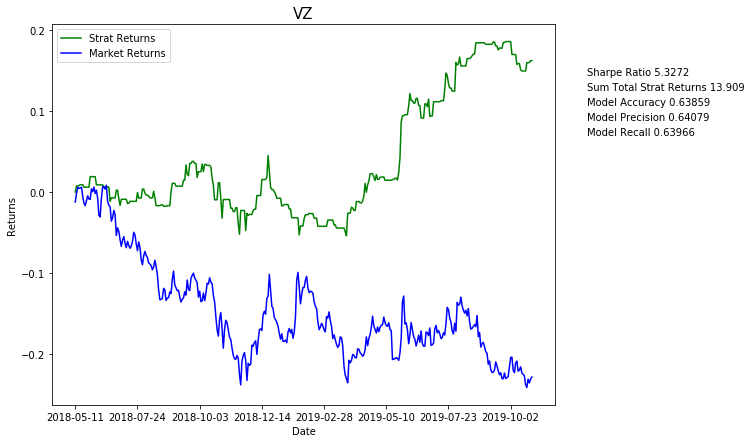

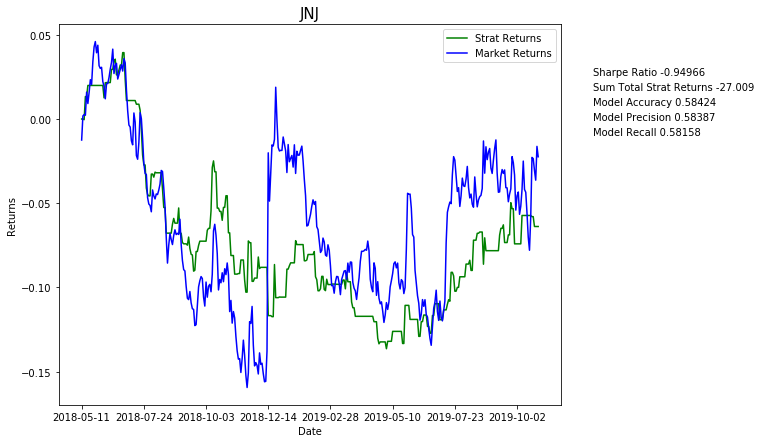

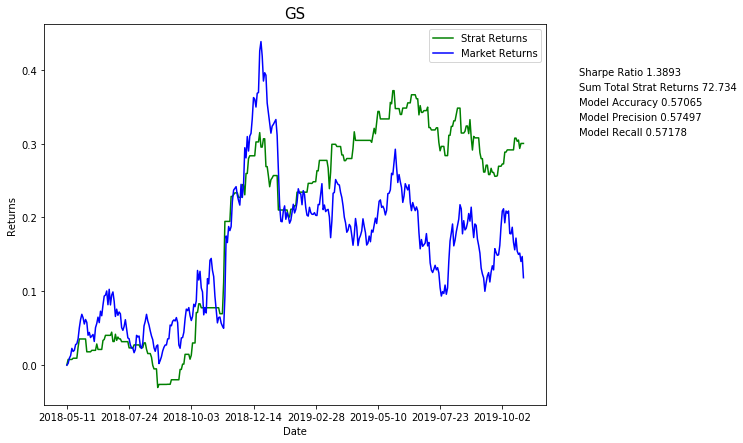

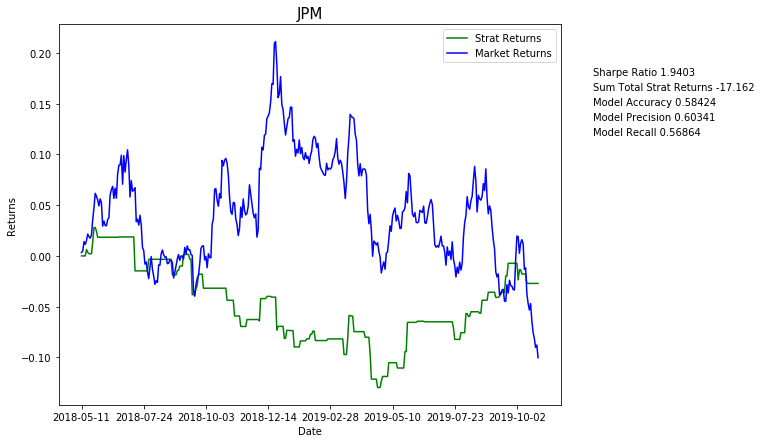

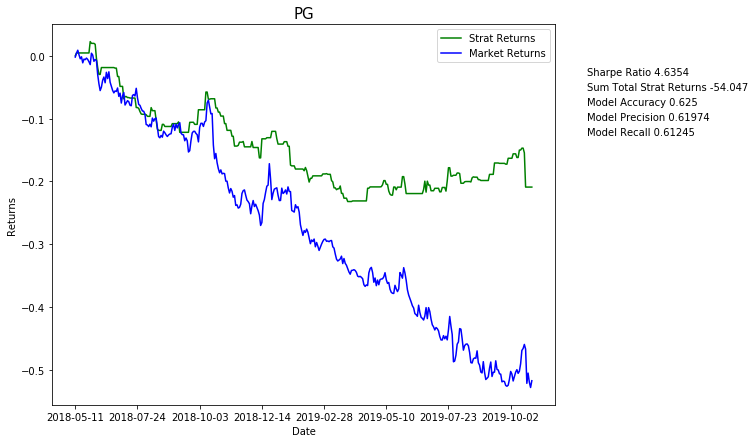

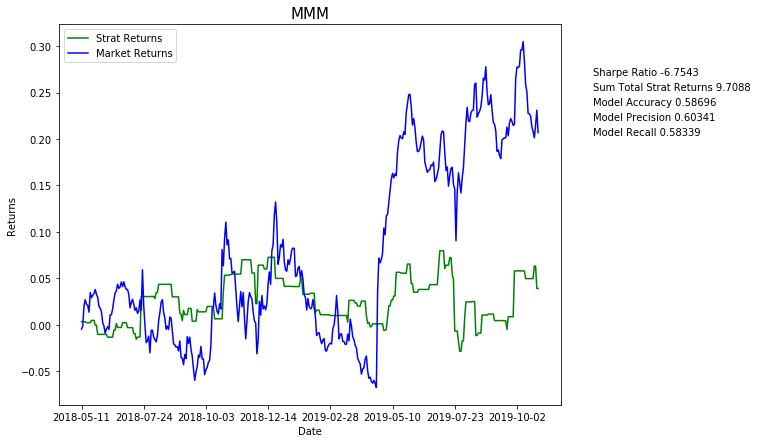

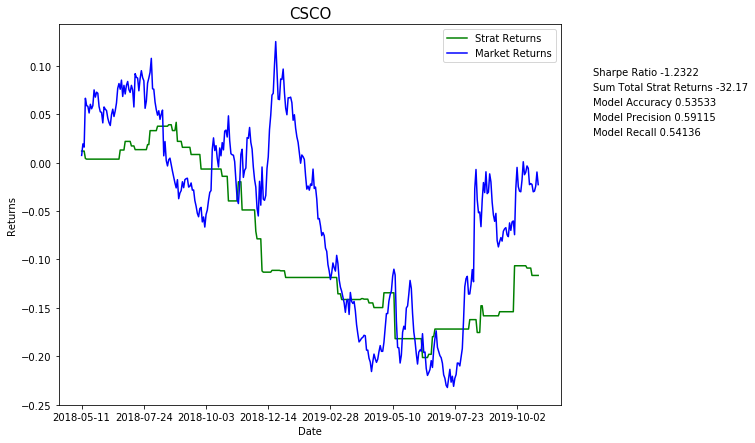

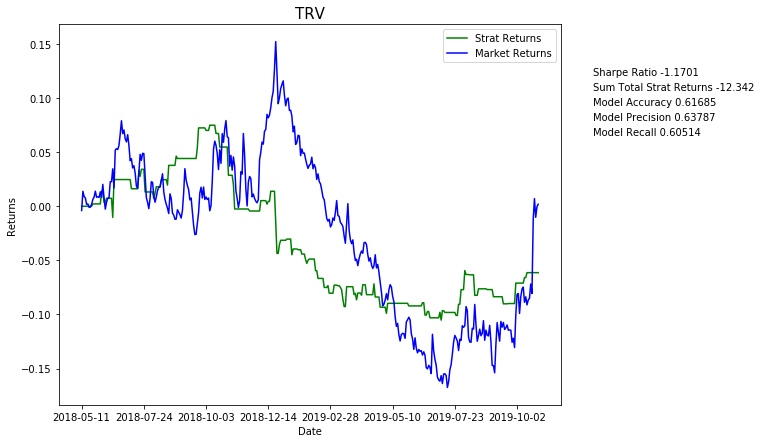

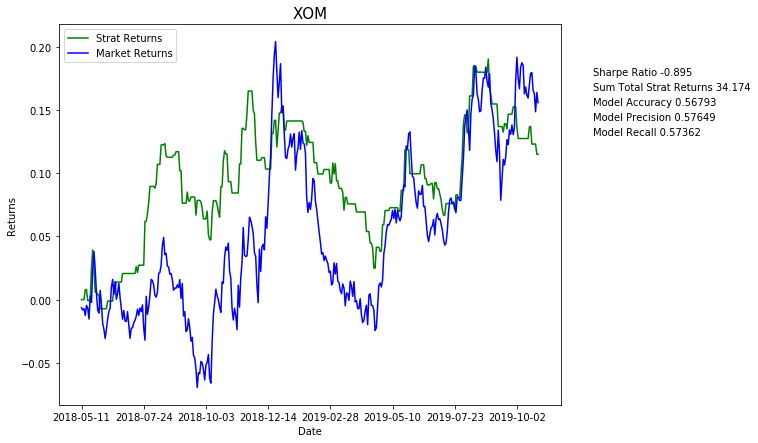

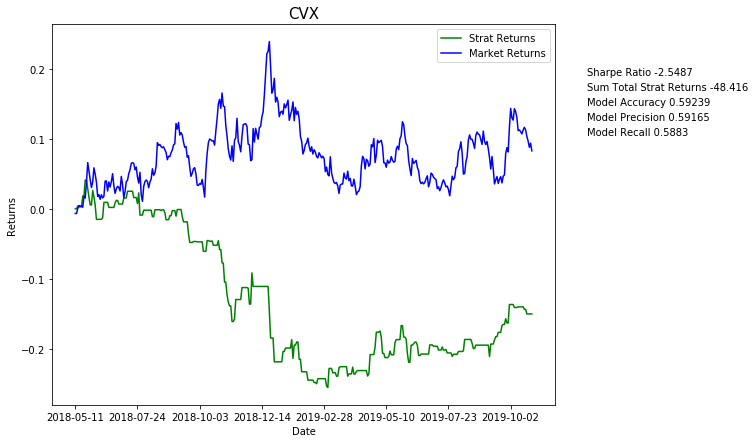

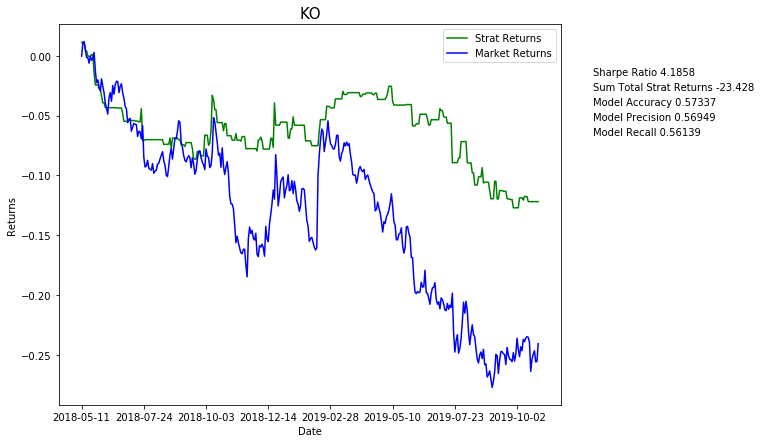

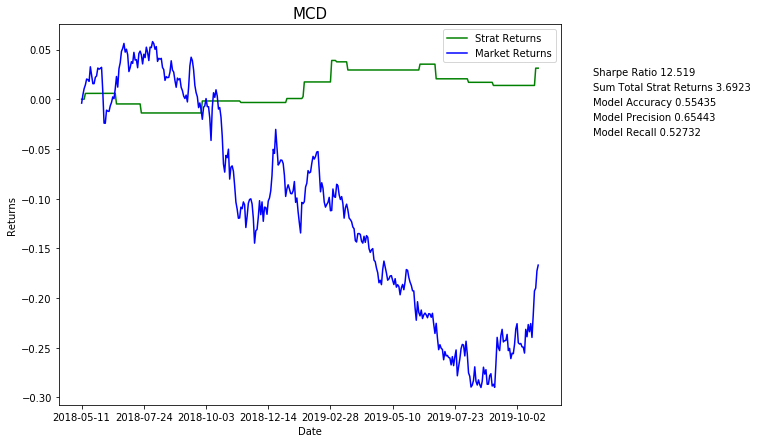

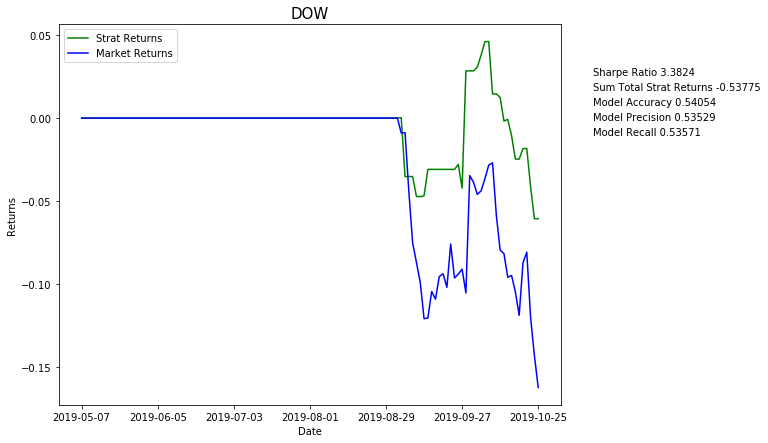

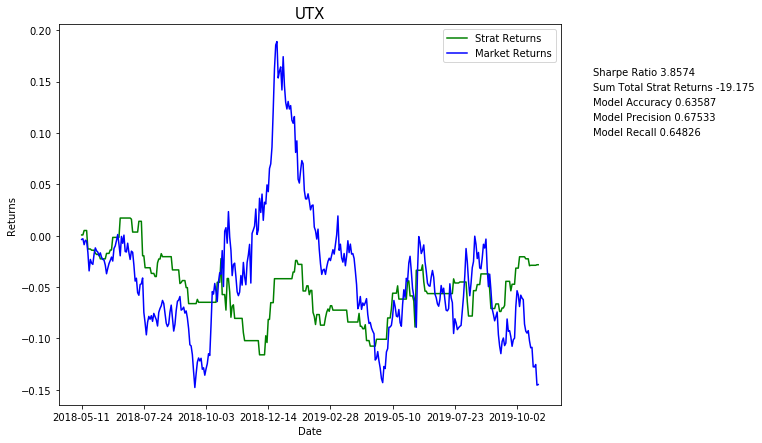

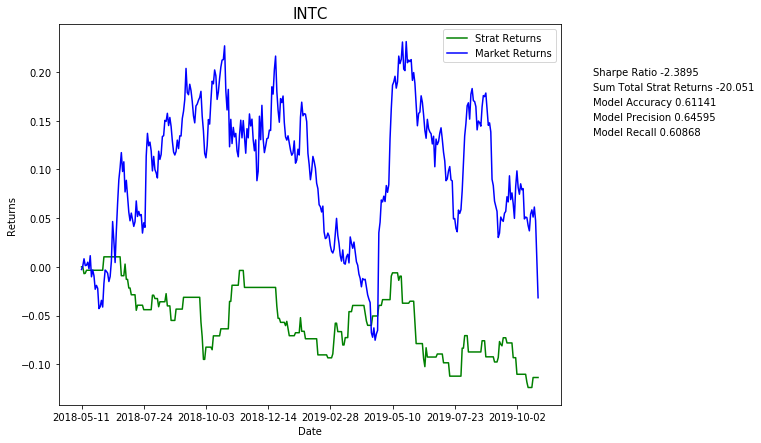

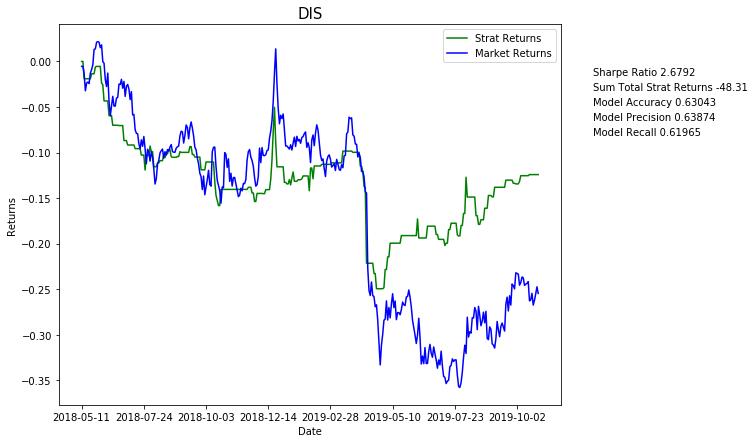

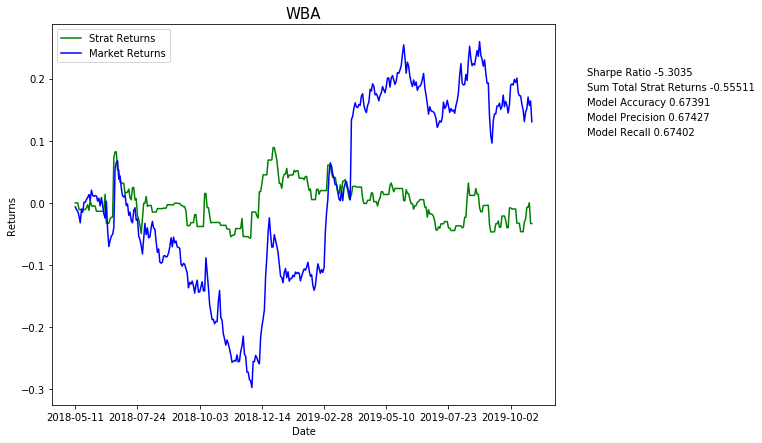

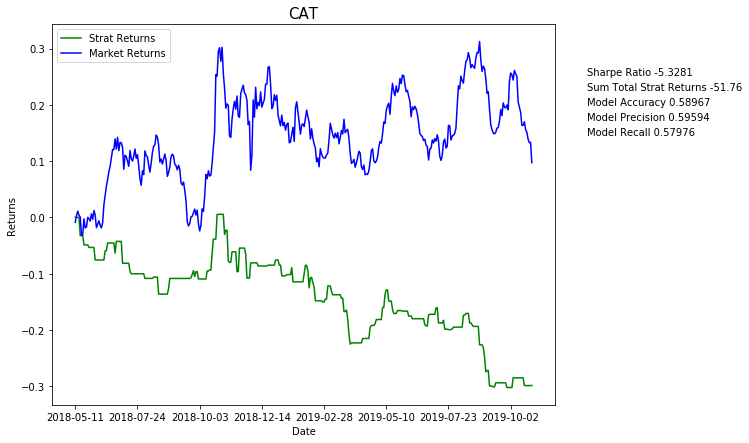

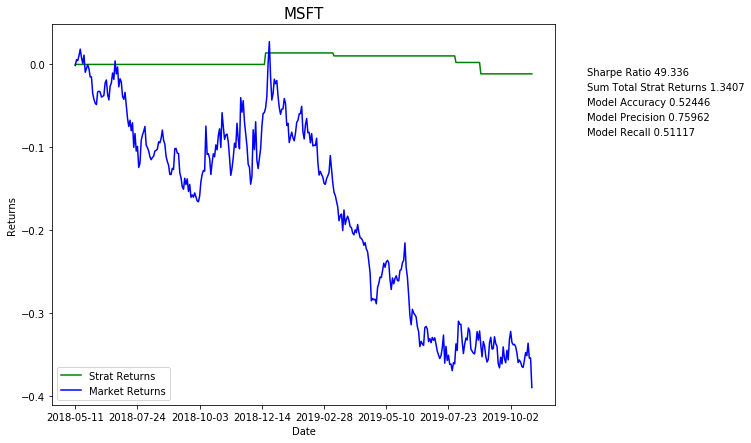

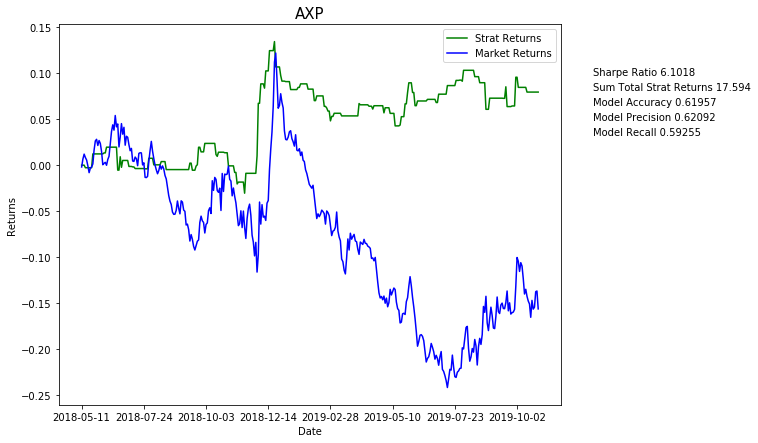

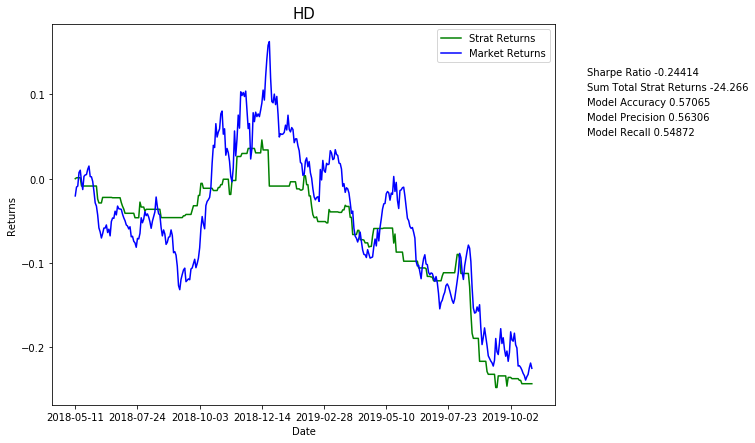

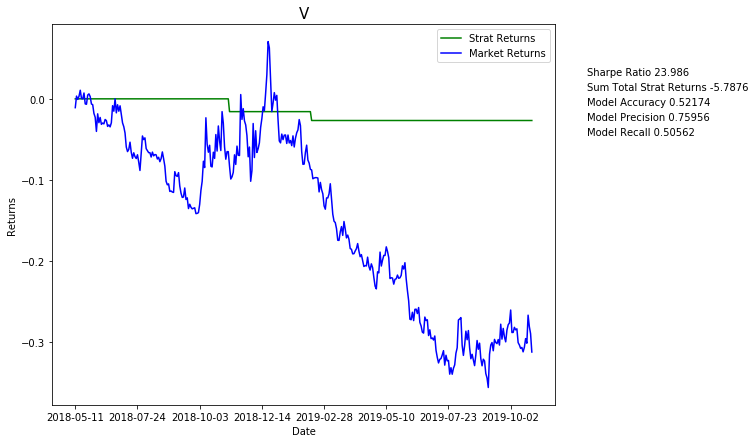

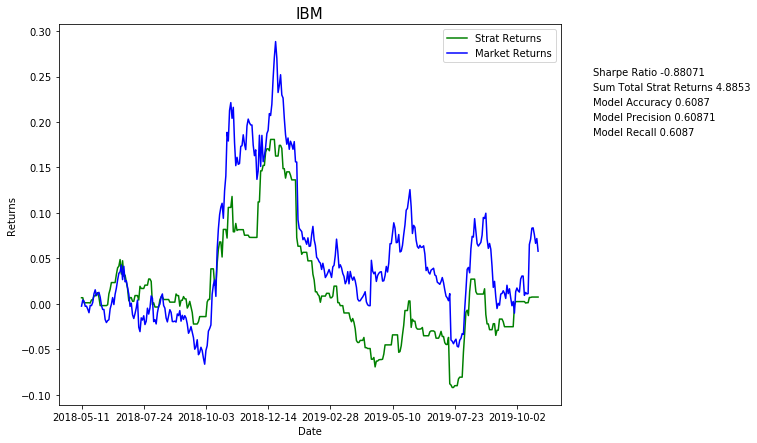

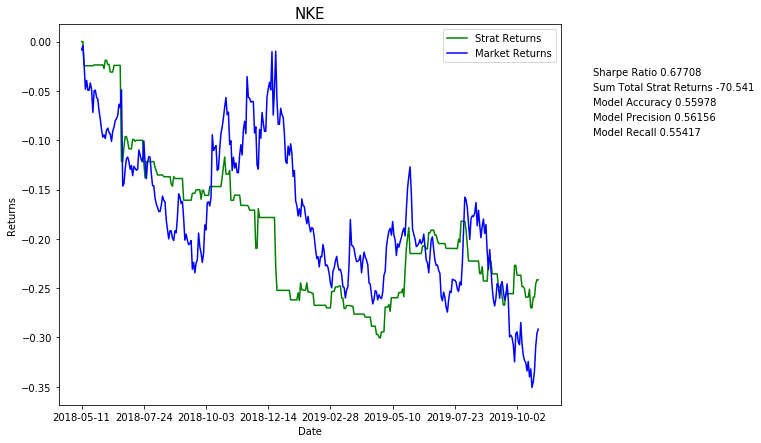

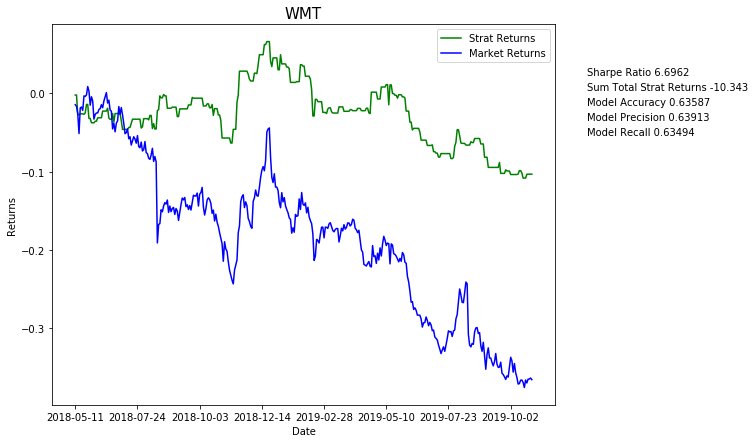

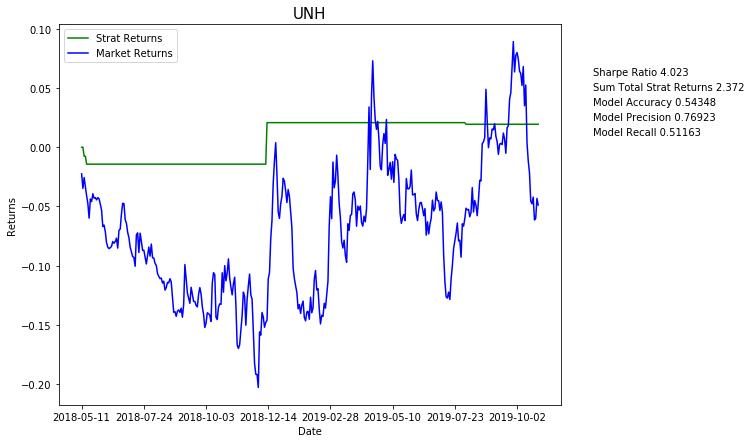

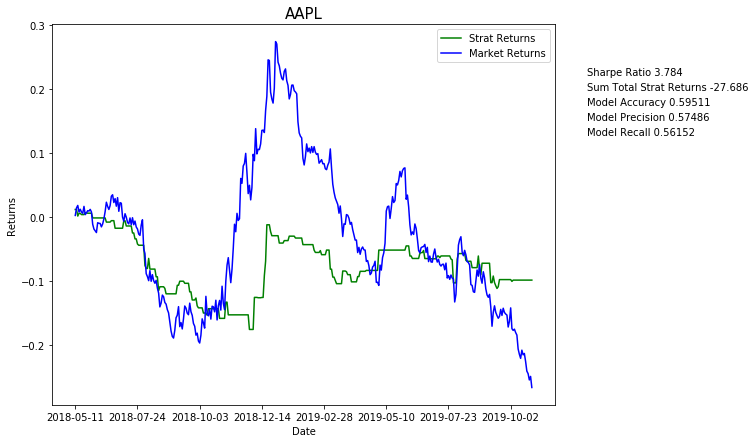

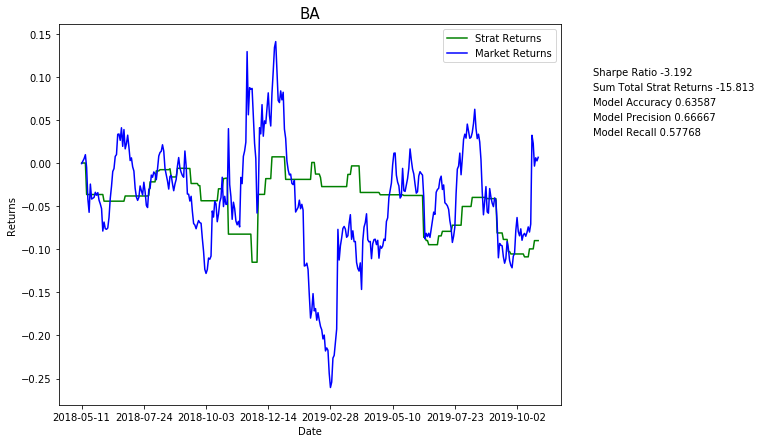

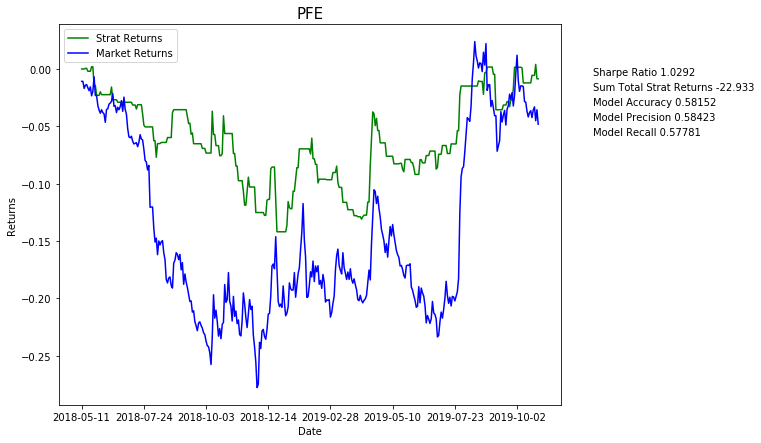

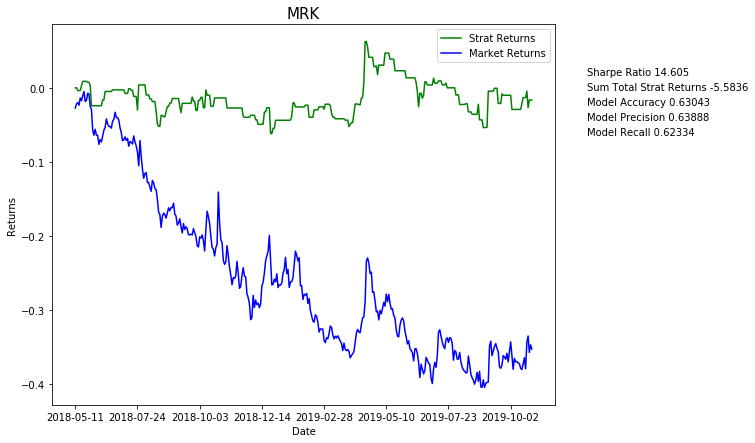

In [12]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

for i in Ticker_List:
    fig, ax = plt.subplots(figsize=(9, 7))

    ax.plot(Stock_Data[i][-prediction_length:].index.values,
            Stock_Data[i]['Total Strat Returns'][-prediction_length:].values, color='g', label="Strat Returns")
    
    ax.plot(Stock_Data[i][-prediction_length:].index.values,
            Stock_Data[i]['Market Returns'][-prediction_length:].values, color='b', label="Market Returns")
    
    ax.set(xlabel= "Date",ylabel="Returns")
    plt.title(i,fontsize=15)
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    
    plt.figtext(.95,0.78, s="Sharpe Ratio "+'{0:.5g}'.format(Model_Dict[i]['Sharpe_Ratio']))
    plt.figtext(.95,0.75, s="Sum Total Strat Returns "+'{0:.5g}'.format(Stock_Data[i]['Total Strat Returns'].sum()))
    plt.figtext(.95,0.72,s="Model Accuracy " +'{0:.5g}'.format(Model_Dict[i]['Accuracy']))
    plt.figtext(.95,0.69,s="Model Precision " +'{0:.5g}'.format(Model_Dict[i]['Precision']))
    plt.figtext(.95,0.66,s="Model Recall " +'{0:.5g}'.format(Model_Dict[i]['Recall']))
    
    plt.legend(loc='best')
    plt.show()

### Conclusion
The model isn't perfect by any means, but it does work for some equities in the Dow Jones Industrial Average.  A few ways that this could be improved:

1. Use the technical indicators to create signals instead of only returns
2. Adapt the model for long/short scenarios
3. Use different technical indicators
4. Create a portfolio including position sizing, transaction costs, slippage etc.

Financial markets are a wonderfully complex place and our model is fairly simple.  There's lots of room for improvement, so take a shot at it.  A link to my Github will be in the references, so feel free to play with the code.
I hope this was helpful in your understanding of support vector machines!

### References

1. https://pdfs.semanticscholar.org/4d9f/4d308e318eb65f02bd12d2abc37ce7493698.pdf
2. https://doi.org/10.1016/j.jfds.2018.04.003
3. http://gide.unileon.es/admin/UploadFolder/journal_of_forecasting.pdf
4. http://cs229.stanford.edu/proj2014/Xinjie%20Di,%20Stock%20Trend%20Prediction%20with%20Technical%20Indicators%20using%20SVM.pdf
5. An Introduction to Statistical Learning